# Coffee Quality Analysis Project

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import re
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

## Loading data

In [3]:
df = pd.read_csv('./coffee_raw_data.csv')

In [4]:
df.head()

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,0,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,2,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
3,3,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,...,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,4,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1339 non-null   int64  
 1   Species                1339 non-null   object 
 2   Owner                  1332 non-null   object 
 3   Country.of.Origin      1338 non-null   object 
 4   Farm.Name              980 non-null    object 
 5   Lot.Number             276 non-null    object 
 6   Mill                   1021 non-null   object 
 7   ICO.Number             1180 non-null   object 
 8   Company                1130 non-null   object 
 9   Altitude               1113 non-null   object 
 10  Region                 1280 non-null   object 
 11  Producer               1107 non-null   object 
 12  Number.of.Bags         1339 non-null   int64  
 13  Bag.Weight             1339 non-null   object 
 14  In.Country.Partner     1339 non-null   object 
 15  Harv

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.columns

Index(['Unnamed: 0', 'Species', 'Owner', 'Country.of.Origin', 'Farm.Name',
       'Lot.Number', 'Mill', 'ICO.Number', 'Company', 'Altitude', 'Region',
       'Producer', 'Number.of.Bags', 'Bag.Weight', 'In.Country.Partner',
       'Harvest.Year', 'Grading.Date', 'Owner.1', 'Variety',
       'Processing.Method', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
       'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points',
       'Total.Cup.Points', 'Moisture', 'Category.One.Defects', 'Quakers',
       'Color', 'Category.Two.Defects', 'Expiration', 'Certification.Body',
       'Certification.Address', 'Certification.Contact', 'unit_of_measurement',
       'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters'],
      dtype='object')

## Data preprocessing

### Data standardization

In [8]:
# selecting only the relevant columns needed for coffee quality analysis
selected_cols = ['Species', 'Country.of.Origin', 'Harvest.Year', 'Processing.Method', 
                 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 
                 'Clean.Cup', 'Sweetness', 'Total.Cup.Points', 'Moisture', 'Category.One.Defects', 
                 'Quakers', 'Category.Two.Defects', 'unit_of_measurement', 'altitude_mean_meters']

In [9]:
# automatic filtering to keep only columns that exist in the dataset
coffee_data = df[[col for col in selected_cols if col in df.columns]]

In [10]:
# unifying column names to snake_case
coffee_data.columns = coffee_data.columns.str.replace('.', '_', regex=False).str.lower()

In [11]:
coffee_data.head()

,species,country_of_origin,harvest_year,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,clean_cup,sweetness,total_cup_points,moisture,category_one_defects,quakers,category_two_defects,unit_of_measurement,altitude_mean_meters
0,Arabica,Ethiopia,2014,Washed / Wet,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,90.58,0.12,0,0.0,0,m,2075.0
1,Arabica,Ethiopia,2014,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,89.92,0.12,0,0.0,1,m,2075.0
2,Arabica,Guatemala,NaN,NaN,8.42,8.50,8.42,8.42,8.33,8.42,10.0,10.0,10.0,89.75,0.00,0,0.0,0,m,1700.0
3,Arabica,Ethiopia,2014,Natural / Dry,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,10.0,89.00,0.11,0,0.0,2,m,2000.0
4,Arabica,Ethiopia,2014,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,88.83,0.12,0,0.0,2,m,2075.0


In [12]:
# distinct values in 'species' column
coffee_data['species'].unique()

array(['Arabica', 'Robusta'], dtype=object)

In [13]:
# distinct values in 'country_of_origin' column
coffee_data['country_of_origin'].sort_values().unique()

array(['Brazil', 'Burundi', 'China', 'Colombia', 'Costa Rica',
       'Cote d?Ivoire', 'Ecuador', 'El Salvador', 'Ethiopia', 'Guatemala',
       'Haiti', 'Honduras', 'India', 'Indonesia', 'Japan', 'Kenya',
       'Laos', 'Malawi', 'Mauritius', 'Mexico', 'Myanmar', 'Nicaragua',
       'Panama', 'Papua New Guinea', 'Peru', 'Philippines', 'Rwanda',
       'Taiwan', 'Tanzania, United Republic Of', 'Thailand', 'Uganda',
       'United States', 'United States (Hawaii)',
       'United States (Puerto Rico)', 'Vietnam', 'Zambia', nan],
      dtype=object)

#### Unifying date formats

In [14]:
# distinct values in 'harvest_year' column
coffee_data['harvest_year'].unique()

array(['2014', nan, '2013', '2012', 'March 2010',
       'Sept 2009 - April 2010', 'May-August', '2009/2010', '2015',
       '2011', '2016', '2015/2016', '2010', 'Fall 2009', '2017',
       '2009 / 2010', '2010-2011', '2009-2010', '2009 - 2010',
       '2013/2014', '2017 / 2018', 'mmm', 'TEST',
       'December 2009-March 2010', '2014/2015', '2011/2012',
       'January 2011', '4T/10', '2016 / 2017', '23 July 2010',
       'January Through April', '1T/2011', '4t/2010', '4T/2010',
       'August to December', 'Mayo a Julio', '47/2010', 'Abril - Julio',
       '4t/2011', 'Abril - Julio /2011', 'Spring 2011 in Colombia.',
       '3T/2011', '2016/2017', '1t/2011', '2018', '4T72010', '08/09 crop'],
      dtype=object)

In [15]:
# a function to extract the year: picks the first 4-digit number in each string as the year, if nothing is found, returns NaN
# \b is a word boundary to ensure matching of whole years, not digits inside longer words like “20105”
# 20\d{2}	matches numbers starting with “20” + two digits → e.g. 2009, 2013, 2021
# 19\d{2}	matches numbers starting with “19” + two digits → e.g. 1998, 1985
# \b is a word boundary to ensure a stop at the end of the 4-digit year
# str(value)) temporarily converts value to a string only for the regex search since regex operates on strings, but the column itself is not converted to string
# match.group() method extracts the actual substring that was matched by the regex pattern, (0) returns the entire match

def extract_year(value):
    # keep missing values
    if pd.isna(value):
        return pd.NA
    # find first 4-digit number
    match = re.search(r'\b(20\d{2}|19\d{2})\b', str(value))
    if match:
        return int(match.group(0))
    else:
        return pd.NA

In [16]:
# applying the function
coffee_data['harvest_year_clean'] = coffee_data['harvest_year'].apply(extract_year).astype('Int64')

In [17]:
# checking the results
# drop_duplicates() removes duplicate pairs of [harvest_year, harvest_year_clean] to see only unique mappings
coffee_data[['harvest_year', 'harvest_year_clean']].drop_duplicates().sort_values('harvest_year_clean')

,harvest_year,harvest_year_clean
190,December 2009-March 2010,2009
74,2009 / 2010,2009
51,Fall 2009,2009
114,2009-2010,2009
17,2009/2010,2009
124,2009 - 2010,2009
13,Sept 2009 - April 2010,2009
439,4T/2010,2010
7,March 2010,2010
493,47/2010,2010


In [18]:
coffee_data['harvest_year_clean'].unique()

<IntegerArray>
[2014, <NA>, 2013, 2012, 2010, 2009, 2015, 2011, 2016, 2017, 2018]
Length: 11, dtype: Int64

In [19]:
# pop() method replaces the column harvest_year with harvest_year_clean and removes harvest_year_clean
coffee_data['harvest_year'] = coffee_data.pop('harvest_year_clean')

#### Standardizing processing methods

In [20]:
# distinct values in 'processing_method' column
coffee_data['processing_method'].unique()

array(['Washed / Wet', nan, 'Natural / Dry', 'Pulped natural / honey',
       'Semi-washed / Semi-pulped', 'Other'], dtype=object)

Coffee processing techniques are typically grouped into 4 categories: 
- Washed (Wet)
- Semi-washed (Semi-pulped, Wet-hulled)
- Natural (Dry, Sun dried)
- Honey (Pulped natural)

In [21]:
# converting to categorical type for performance
coffee_data['processing_method'] = coffee_data['processing_method'].astype('category')

In [22]:
# counting how many rows have 'processing_method' equal to 'Other'
(coffee_data['processing_method'] == 'Other').sum()

## alternative code:
## coffee_data[coffee_data['processing_method']=='Other']['processing_method'].count()

np.int64(26)

In [23]:
# consolidating categories to reduce noise and category fragmentation
mapping = {
    'Pulped natural / honey': 'Honey',
    'Semi-washed / Semi-pulped': 'Semi-washed',
    'Washed / Wet': 'Washed',
    'Natural / Dry': 'Natural',
}
coffee_data['processing_method'] = coffee_data['processing_method'].replace(mapping)


#### Altitude conversion from feet to meters

In [24]:
# distinct values in 'unit_of_measurement' column
coffee_data['unit_of_measurement'].unique()

array(['m', 'ft'], dtype=object)

In [25]:
# converting all altitude_mean_meters values that are in feet (ft) into meters (m): 1 foot = 0.3048 meters
# df.loc[condition, column] selects rows where the condition is true
# the multiplication applies only to rows where the unit is 'ft'
coffee_data.loc[coffee_data['unit_of_measurement'] == 'ft', 'altitude_mean_meters'] *= 0.3048

In [26]:
# removing the column 'unit_of_measurement'
coffee_data = coffee_data.drop(columns='unit_of_measurement')

### Data cleaning

#### Missing values

In [27]:
# calculating the number of missing values
coffee_data.isna().sum()

species                   0
country_of_origin         1
harvest_year             64
processing_method       170
aroma                     0
flavor                    0
aftertaste                0
acidity                   0
body                      0
balance                   0
uniformity                0
clean_cup                 0
sweetness                 0
total_cup_points          0
moisture                  0
category_one_defects      0
quakers                   1
category_two_defects      0
altitude_mean_meters    230
dtype: int64

__Column country_of_origin__

In [28]:
# checking the row in 'country_of_origin' column with the missing value
coffee_data[coffee_data['country_of_origin'].isna()]

,species,country_of_origin,harvest_year,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,clean_cup,sweetness,total_cup_points,moisture,category_one_defects,quakers,category_two_defects,altitude_mean_meters
1197,Arabica,NaN,<NA>,NaN,6.75,6.75,6.42,6.83,7.58,7.5,10.0,10.0,10.0,79.08,0.1,0,0.0,3,NaN


In [29]:
# dropping this row since there is only 1 and its country of origin, harvest year and processing method cannot be defined
coffee_data = coffee_data.dropna(subset=['country_of_origin'])

__Column harvest_year__

In [30]:
# subset of rows with missing harvest year
coffee_data[coffee_data['harvest_year'].isna()]

,species,country_of_origin,harvest_year,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,clean_cup,sweetness,total_cup_points,moisture,category_one_defects,quakers,category_two_defects,altitude_mean_meters
2,Arabica,Guatemala,<NA>,NaN,8.42,8.50,8.42,8.42,8.33,8.42,10.00,10.00,10.00,89.75,0.00,0,0.0,0,1700.0
16,Arabica,Indonesia,<NA>,NaN,8.33,8.25,7.83,7.75,8.50,8.42,10.00,10.00,10.00,87.42,0.03,0,0.0,0,1500.0
30,Arabica,Nicaragua,<NA>,NaN,7.92,8.25,8.00,8.33,8.00,8.08,10.00,10.00,10.00,86.58,0.08,0,0.0,2,NaN
95,Arabica,United States (Hawaii),<NA>,NaN,7.50,7.92,8.25,7.83,7.92,7.75,10.00,10.00,10.00,85.08,0.00,0,0.0,0,NaN
104,Arabica,United States (Hawaii),<NA>,NaN,7.75,7.92,7.75,7.75,8.00,8.00,10.00,10.00,10.00,85.00,0.00,0,0.0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167,Arabica,Colombia,<NA>,NaN,7.25,7.17,7.00,6.75,7.17,7.33,10.00,10.00,10.00,79.58,0.10,0,0.0,4,1800.0
1191,Arabica,Mexico,<NA>,NaN,6.75,6.75,6.83,7.25,7.58,7.08,10.00,10.00,10.00,79.17,0.01,0,0.0,8,1200.0
1220,Arabica,United States (Hawaii),<NA>,NaN,7.92,6.83,7.08,7.42,6.75,7.33,8.67,9.33,10.00,78.58,0.00,0,0.0,0,NaN
1242,Arabica,Colombia,<NA>,NaN,7.42,7.17,7.00,7.17,7.67,7.17,8.67,9.33,9.33,78.00,0.10,1,0.0,3,NaN


In [31]:
# checking if harvest year can be derived from processing method
coffee_data.groupby('processing_method',  dropna=False)['harvest_year'].apply(lambda x: x.isna().sum()).sort_values(ascending=False)

processing_method
NaN            56
Washed          4
Honey           2
Natural         1
Other           0
Semi-washed     0
Name: harvest_year, dtype: int64

Most rows with a missing harvest year also lack a processing method, so harvest year cannot be reliably inferred from processing method.

In [32]:
# checking if there is a connection between harvest year and coffee species
coffee_data.groupby('species')['harvest_year'].apply(lambda x: x.isna().sum())

species
Arabica    63
Robusta     0
Name: harvest_year, dtype: int64

All rows with a missing harvest year belong to the Arabica species.

In [33]:
# distribution of Arabica rows across harvest years
coffee_data[coffee_data['species']=='Arabica'].groupby('harvest_year', dropna=False)['harvest_year'].size()

harvest_year
2009     20
2010     25
2011     36
2012    352
2013    199
2014    245
2015    153
2016    129
2017     87
2018      1
<NA>     63
Name: harvest_year, dtype: Int64

__Conclusion:__ \
The distribution of Arabica rows across harvest years is uneven. \
Harvest year cannot be derived from it.

In [34]:
# checking if harvest year can be derived from country of origin
coffee_data[coffee_data['harvest_year'].isna()].groupby('country_of_origin').size().sort_values(ascending=False)

country_of_origin
United States (Hawaii)    19
Colombia                  15
Brazil                     5
Thailand                   5
Guatemala                  4
Mexico                     3
Nicaragua                  3
Costa Rica                 2
Ethiopia                   2
Kenya                      2
Indonesia                  1
Japan                      1
Peru                       1
dtype: int64

In [35]:
# comparing the number of missing entries for harvest_year with the total entries per country
coffee_data.groupby('country_of_origin').agg(
    missing_harvest_year=('harvest_year', lambda x: x.isna().sum()),
    total_entries=('harvest_year', 'size')
).sort_values('missing_harvest_year', ascending=False)


,missing_harvest_year,total_entries
country_of_origin,,
United States (Hawaii),19,73
Colombia,15,183
Brazil,5,132
Thailand,5,32
Guatemala,4,181
Nicaragua,3,26
Mexico,3,236
Kenya,2,25
Costa Rica,2,51


In [36]:
# checking the range of harvest years in United States (Hawaii)
coffee_data[coffee_data['country_of_origin']=='United States (Hawaii)']['harvest_year'].unique()

<IntegerArray>
[2009, 2012, 2010, 2014, <NA>, 2013, 2011]
Length: 7, dtype: Int64

In [37]:
# checking the range of harvest years in Indonesia
coffee_data[coffee_data['country_of_origin']=='Indonesia']['harvest_year'].unique()

<IntegerArray>
[<NA>, 2012, 2016, 2017, 2015, 2010, 2014, 2013, 2011]
Length: 9, dtype: Int64

__Conclusion:__ \
Due to the large spread of harvest years per country, the lack of chronological ordering, and the frequent absence of processing method, \
missing harvest years cannot be reliably imputed or inferred from the existing data.

__Column processing_method__

In [38]:
# countries with missing values in processing_method
# size() counts all rows in the group, including NaNs
# count() will not work here because it ignores NaN values and counts only non-missing values,
# so it will return 0 in this case because [coffee_data['processing_method'].isna()] is NaN in all those filtered rows
coffee_data[coffee_data['processing_method'].isna()].groupby('country_of_origin').size().sort_values(ascending=False)

country_of_origin
Colombia                        35
United States (Hawaii)          24
Ethiopia                        19
Brazil                          14
Thailand                        11
Uganda                          10
Nicaragua                        8
Guatemala                        8
Mexico                           7
India                            6
Taiwan                           5
Honduras                         4
El Salvador                      4
Indonesia                        3
Peru                             2
Ecuador                          2
Costa Rica                       2
Kenya                            1
Burundi                          1
Tanzania, United Republic Of     1
Haiti                            1
Mauritius                        1
dtype: int64

In [39]:
# overview of countries with missing processing_method and of other methods that are present in these countries
countries_methods = coffee_data.groupby('country_of_origin').agg(
    missing_count = ('processing_method', lambda x: x.isna().sum()),
    unique_methods = ('processing_method', lambda x: sorted(x.dropna().astype(str).unique()))
).loc[lambda dx: dx['missing_count'] > 0].sort_values('missing_count', ascending=False)

countries_methods

,missing_count,unique_methods
country_of_origin,,
Colombia,35,"[Natural, Washed]"
United States (Hawaii),24,"[Natural, Washed]"
Ethiopia,19,"[Natural, Washed]"
Brazil,14,"[Honey, Natural, Other, Semi-washed, Washed]"
Thailand,11,"[Honey, Natural, Washed]"
Uganda,10,"[Natural, Semi-washed, Washed]"
Nicaragua,8,"[Natural, Other, Washed]"
Guatemala,8,"[Natural, Other, Washed]"
Mexico,7,"[Natural, Semi-washed, Washed]"


In [40]:
# filling NaN values based on the distribution of existing methods in each country
# mask selects only NaN rows in that country
# n_missing = mask.sum() → how many NaNs to fill
# existing_methods.value_counts(normalize=True) → probabilities for sampling
# np.random.choice(...) generates an array of random methods exactly for the NaN rows
# coffee_data.loc[mask, 'processing_method'] = ... → assigns the array directly only to the NaN positions

np.random.seed(42)   # reproducibility

for country, group in coffee_data.groupby('country_of_origin'):
    mask = (coffee_data['country_of_origin'] == country) & (coffee_data['processing_method'].isna())
    n_missing = mask.sum()
    if n_missing == 0:
        continue
    existing_methods = group['processing_method'].dropna()
    if len(existing_methods) == 0:
        continue  # skip countries with all NaNs
    probs = existing_methods.value_counts(normalize=True)
    coffee_data.loc[mask, 'processing_method'] = np.random.choice(
        probs.index, size=n_missing, p=probs.values
    )

In [41]:
coffee_data[coffee_data['country_of_origin']=='Mauritius']

,species,country_of_origin,harvest_year,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,clean_cup,sweetness,total_cup_points,moisture,category_one_defects,quakers,category_two_defects,altitude_mean_meters
1071,Arabica,Mauritius,2016,NaN,7.25,7.25,7.17,7.17,7.25,7.17,10.0,10.0,10.0,80.5,0.12,0,0.0,0,280.0


In [42]:
# assigning the method "Other" for Mauritius, since there is no data to compute a country-specific mode
coffee_data['processing_method'].fillna('Other', inplace=True)

__Column quakers__

In [43]:
# checking which row in the 'quakers' column has a missing value
coffee_data[coffee_data['quakers'].isna()]

,species,country_of_origin,harvest_year,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,clean_cup,sweetness,total_cup_points,moisture,category_one_defects,quakers,category_two_defects,altitude_mean_meters
366,Arabica,Colombia,2013,Washed,7.58,7.67,7.58,7.75,7.58,7.75,10.0,10.0,10.0,83.5,0.11,0,NaN,2,1750.0


In [44]:
# the number of rows with this country of origin and harvest year
coffee_data[(coffee_data['country_of_origin'] == 'Colombia') & (coffee_data['harvest_year'] == 2013)]['country_of_origin'].count()

np.int64(40)

In [45]:
# distinct values in 'quakers' column for this country and harvest year
coffee_data[(coffee_data['country_of_origin'] == 'Colombia') & (coffee_data['harvest_year'] == 2013)]['quakers'].unique()

array([ 0., nan])

In [46]:
# replacing NaN with 0 since all quaker values for this country and this year are 0
# inplace=True modifies the DataFrame, while fillna(0) does not modify it unless the value is assigned back (e.g. coffee_data = coffee_data.fillna(0))
coffee_data['quakers'].fillna(0, inplace=True)

In [47]:
coffee_data['quakers'].unique()

array([ 0.,  1.,  4.,  2.,  5.,  6.,  3., 11.,  7.,  9.,  8.])

In [48]:
# converting 'quakers' from float to int
## coffee_data['quakers'] = coffee_data['quakers'].fillna(0).astype(int)
coffee_data['quakers'] = coffee_data['quakers'].astype(int)

__Column altitude_mean_meters__

In [49]:
coffee_data.head()

,species,country_of_origin,harvest_year,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,clean_cup,sweetness,total_cup_points,moisture,category_one_defects,quakers,category_two_defects,altitude_mean_meters
0,Arabica,Ethiopia,2014,Washed,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,90.58,0.12,0,0,0,2075.0
1,Arabica,Ethiopia,2014,Washed,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,89.92,0.12,0,0,1,2075.0
2,Arabica,Guatemala,<NA>,Washed,8.42,8.50,8.42,8.42,8.33,8.42,10.0,10.0,10.0,89.75,0.00,0,0,0,1700.0
3,Arabica,Ethiopia,2014,Natural,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,10.0,89.00,0.11,0,0,2,2000.0
4,Arabica,Ethiopia,2014,Washed,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,88.83,0.12,0,0,2,2075.0


In [50]:
# countries with missing values in altitude_mean_meters
coffee_data[coffee_data['altitude_mean_meters'].isna()].groupby('country_of_origin').size().sort_values(ascending=False)

country_of_origin
United States (Hawaii)          71
Colombia                        33
Brazil                          27
Guatemala                       25
Ethiopia                        14
Thailand                        12
Peru                             8
Nicaragua                        8
Costa Rica                       5
Taiwan                           5
Mexico                           4
Tanzania, United Republic Of     3
Uganda                           2
Kenya                            2
Indonesia                        2
India                            2
Honduras                         2
El Salvador                      2
Ecuador                          1
Vietnam                          1
dtype: int64

In [51]:
# number of distinct values in 'altitude_mean_meters' column for United States (Hawaii)
coffee_data[coffee_data['country_of_origin'] == 'United States (Hawaii)']['altitude_mean_meters'].nunique()

2

In [52]:
# number of distinct values in 'altitude_mean_meters' column for Colombia
coffee_data[coffee_data['country_of_origin'] == 'Colombia']['altitude_mean_meters'].nunique()

29

In [53]:
# harvest years with missing values in altitude_mean_meters
coffee_data[coffee_data['altitude_mean_meters'].isna()].groupby('harvest_year').size().sort_values(ascending=False)

harvest_year
2012    59
2016    36
2013    29
2014    28
2015    11
2009     9
2017     8
2010     7
2011     6
dtype: int64

In [54]:
# number of distinct values in 'altitude_mean_meters' column for harvest year 2012
coffee_data[coffee_data['harvest_year'] == 2012]['altitude_mean_meters'].nunique()

75

In [55]:
# processing_methods with missing values in altitude_mean_meters
coffee_data[coffee_data['altitude_mean_meters'].isna()].groupby('processing_method', observed=True).size().sort_values(ascending=False)

processing_method
Natural        109
Washed         107
Semi-washed      7
Honey            4
Other            2
dtype: int64

In [56]:
# number of distinct values in 'altitude_mean_meters' column for natural processing_method
coffee_data[coffee_data['processing_method'] == 'Natural']['altitude_mean_meters'].nunique()

83

In [57]:
# assessing whether altitude can be inferred from combinations of 2 features
# For each relevant column pair, the data is grouped to check how often the grouped rows share exactly one altitude value.
# Higher percentages indicate stronger predictive relationships and better candidates for imputation.

goal = 'altitude_mean_meters'
cols = ['species', 'country_of_origin', 'harvest_year', 'processing_method']

results = []

for combo in itertools.combinations(cols, 2):
    nunique_values = (
        coffee_data
        .groupby(list(combo), observed=True)[goal]
        .nunique(dropna=True)
    )
    
    # percent of groups where altitude is uniquely determined
    percent_unique = (nunique_values == 1).mean() * 100
    
    results.append({
        'column_1': combo[0],
        'column_2': combo[1],
        'percent_unique_altitude': percent_unique
    })

column_pairs = pd.DataFrame(results)
column_pairs.sort_values('percent_unique_altitude', ascending=False, inplace=True)

column_pairs

,column_1,column_2,percent_unique_altitude
3,country_of_origin,harvest_year,35.570470
4,country_of_origin,processing_method,28.048780
1,species,harvest_year,25.000000
0,species,country_of_origin,21.951220
5,harvest_year,processing_method,11.428571
2,species,processing_method,0.000000


__Conclusion:__\
The missing altitude values do not exhibit any consistent pattern across processing methods, harvest years, or countries of origin. \
They are distributed irregularly among these columns, indicating that altitude cannot be reliably inferred from any single column or combination of these attributes. \
As a result, the dataset provides no clear relationship that would allow meaningful or accurate imputation of altitude values based on the available features.

### Data formatting

In [58]:
coffee_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1338
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   species               1338 non-null   object  
 1   country_of_origin     1338 non-null   object  
 2   harvest_year          1275 non-null   Int64   
 3   processing_method     1338 non-null   category
 4   aroma                 1338 non-null   float64 
 5   flavor                1338 non-null   float64 
 6   aftertaste            1338 non-null   float64 
 7   acidity               1338 non-null   float64 
 8   body                  1338 non-null   float64 
 9   balance               1338 non-null   float64 
 10  uniformity            1338 non-null   float64 
 11  clean_cup             1338 non-null   float64 
 12  sweetness             1338 non-null   float64 
 13  total_cup_points      1338 non-null   float64 
 14  moisture              1338 non-null   float64 
 15  category_

In [59]:
# rearranging columns by index for easier analysis and readability
coffee_data = coffee_data.iloc[:, [0, 1, 18, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 11, 16, 15, 17, 13]]

In [60]:
coffee_data.head()

,species,country_of_origin,altitude_mean_meters,harvest_year,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,sweetness,moisture,clean_cup,quakers,category_one_defects,category_two_defects,total_cup_points
0,Arabica,Ethiopia,2075.0,2014,Washed,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,0.12,10.0,0,0,0,90.58
1,Arabica,Ethiopia,2075.0,2014,Washed,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,0.12,10.0,0,0,1,89.92
2,Arabica,Guatemala,1700.0,<NA>,Washed,8.42,8.50,8.42,8.42,8.33,8.42,10.0,10.0,0.00,10.0,0,0,0,89.75
3,Arabica,Ethiopia,2000.0,2014,Natural,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,0.11,10.0,0,0,2,89.00
4,Arabica,Ethiopia,2075.0,2014,Washed,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,0.12,10.0,0,0,2,88.83


## Exploratory data analysis (EDA)

In [61]:
# exploring statistics
coffee_data.describe().T

,count,mean,std,min,25%,50%,75%,max
altitude_mean_meters,1109.0,1685.666394,8677.408326,1.0,950.0,1300.0,1600.0,190164.0
harvest_year,1275.0,2013.579608,1.79889,2009.0,2012.0,2013.0,2015.0,2018.0
aroma,1338.0,7.567317,0.37704,0.0,7.42,7.58,7.75,8.75
flavor,1338.0,7.521001,0.398033,0.0,7.33,7.58,7.75,8.83
aftertaste,1338.0,7.401816,0.403723,0.0,7.25,7.42,7.58,8.67
acidity,1338.0,7.536233,0.379478,0.0,7.33,7.58,7.75,8.75
body,1338.0,7.517451,0.370198,0.0,7.33,7.5,7.67,8.58
balance,1338.0,7.518027,0.409096,0.0,7.33,7.5,7.75,8.75
uniformity,1338.0,9.834753,0.55478,0.0,10.0,10.0,10.0,10.0
sweetness,1338.0,9.856584,0.61632,0.0,10.0,10.0,10.0,10.0


### Outliers in total cup points

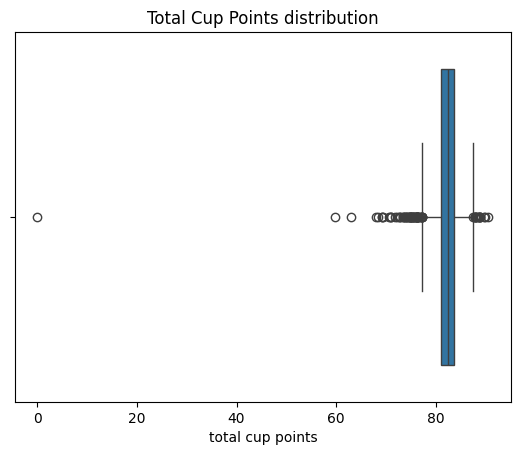

In [62]:
# checking for outliers in the column 'total_cup_points'
sns.boxplot(data=coffee_data, x='total_cup_points')
plt.title("Total Cup Points distribution")
plt.xlabel("total cup points")
plt.show()

In [63]:
coffee_data[coffee_data['total_cup_points']<=50]

,species,country_of_origin,altitude_mean_meters,harvest_year,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,sweetness,moisture,clean_cup,quakers,category_one_defects,category_two_defects,total_cup_points
1310,Arabica,Honduras,1400.0,2017,Washed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12,0.0,0,0,2,0.0


In [64]:
coffee_data[(coffee_data['country_of_origin']=='Honduras') & (coffee_data['species']=='Arabica') & (coffee_data['harvest_year']==2017) & (coffee_data['processing_method']=='Washed')]['total_cup_points'].unique()

array([84.  , 82.5 , 82.42, 82.33, 82.  , 81.92, 81.5 , 80.5 , 79.17,
        0.  ])

In [65]:
outlier_mean = coffee_data[(coffee_data['country_of_origin']=='Honduras') & (coffee_data['species']=='Arabica') & (coffee_data['harvest_year']==2017) & (coffee_data['processing_method']=='Washed')]['total_cup_points'].mean()
outlier_mean

np.float64(73.634)

In [66]:
# replacing the outlier with the average value for this country, specie, processing method and harvest year
coffee_data.loc[coffee_data['total_cup_points'] == coffee_data['total_cup_points'].min(), 'total_cup_points'] = outlier_mean

### Outliers and analysis pipeline for altitude

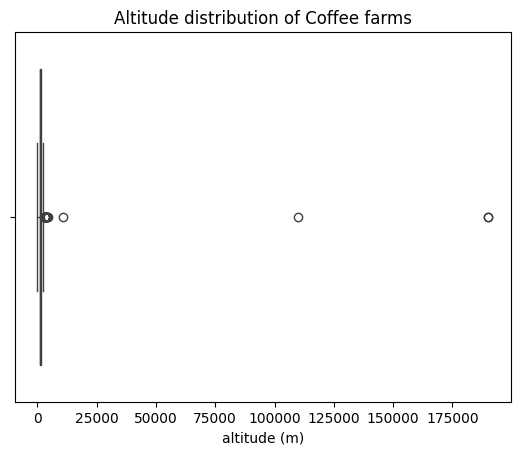

In [67]:
# checking for outliers in the column 'altitude_mean_meters'
sns.boxplot(data=coffee_data, x='altitude_mean_meters')
plt.title("Altitude distribution of Coffee farms")
plt.xlabel("altitude (m)")
plt.show()

#### Automatic outlier detection

In [68]:
# outliers identification through the IQR method
Q1 = coffee_data['altitude_mean_meters'].quantile(0.25)
Q3 = coffee_data['altitude_mean_meters'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Boolean mask
outliers = (coffee_data['altitude_mean_meters'] < lower_bound) | (coffee_data['altitude_mean_meters'] > upper_bound)

print("Outliers detected:", outliers.sum())
coffee_data[outliers].sort_values(['country_of_origin', 'altitude_mean_meters'])

Outliers detected: 18


,species,country_of_origin,altitude_mean_meters,harvest_year,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,sweetness,moisture,clean_cup,quakers,category_one_defects,category_two_defects,total_cup_points
543,Arabica,Brazil,11000.0,2014,Semi-washed,7.08,7.50,7.50,7.83,7.75,7.67,10.00,10.00,0.11,10.00,0,0,16,82.92
628,Arabica,Colombia,3850.0,2011,Washed,7.33,7.58,7.42,7.42,7.67,7.67,10.00,10.00,0.11,10.00,0,0,0,82.67
215,Arabica,Guatemala,3280.0,2016,Washed,7.58,7.83,7.58,7.83,7.83,7.67,10.00,10.00,0.10,10.00,0,0,2,84.17
837,Arabica,Guatemala,3280.0,2015,Washed,7.58,7.50,7.33,7.42,7.58,7.25,10.00,10.00,0.10,10.00,0,2,6,81.83
1001,Arabica,Guatemala,3280.0,2016,Washed,7.42,7.25,7.17,7.50,7.25,7.17,10.00,10.00,0.09,10.00,0,0,8,81.00
896,Arabica,Guatemala,190164.0,2017,Washed,7.42,7.42,7.08,7.50,7.42,7.33,10.00,10.00,0.12,10.00,0,0,0,81.58
1144,Arabica,Guatemala,190164.0,2016,Washed,7.50,7.42,7.25,7.58,7.33,7.42,9.33,9.33,0.10,9.33,4,0,1,79.75
1316,Robusta,India,3000.0,2012,Washed,8.00,7.92,7.67,8.00,7.75,7.92,10.00,7.75,0.00,10.00,0,0,0,82.75
1318,Robusta,India,3140.0,2017,Washed,7.67,7.75,7.83,7.67,7.92,7.83,10.00,7.92,0.10,10.00,0,0,0,82.50
1312,Robusta,India,3170.0,2017,Washed,8.00,7.75,7.92,8.00,7.92,7.92,10.00,8.00,0.00,10.00,0,0,2,83.50


#### Outliers correction

According to ChatGPT, the highest recorded coffee farms in the countries listed above are located below 2000 m. \
So all values detected as outliers will be replaced with country-level medians, since altitude depends on local geography.

In [69]:
# computing median per country
country_medians = coffee_data.groupby('country_of_origin')['altitude_mean_meters'].median()

# replacing outliers
coffee_data.loc[outliers, 'altitude_mean_meters'] = (coffee_data.loc[outliers, 'country_of_origin'].map(country_medians))

#### Detecting countries with inconsistent altitude data

Criteria for inconsistency:
- Range too wide
- Contains extreme outliers
- Very high variance
- Median < 50m or > 3000m (likely wrong)

In [70]:
# detecting countries with inconsistent altitude reporting
country_stats = (
    coffee_data
    .groupby('country_of_origin')['altitude_mean_meters']
    .agg(['min', 'max', 'median', 'std', 'count'])
    .assign(
        range_diff=lambda d: d['max'] - d['min'],
        coef_var=lambda d: d['std'] / d['median']
    )
)

# defining inconsistency rules
inconsistent = country_stats[
    (country_stats['max'] > 3500) |        # extremely high — likely wrong
    (country_stats['min'] < 0)     |       # negative altitude = impossible
    (country_stats['range_diff'] > 2000) | # huge spread, suspicious
    (country_stats['coef_var'] > 1)        # very high variability
]

inconsistent

,min,max,median,std,count,range_diff,coef_var
country_of_origin,,,,,,,
Colombia,165.000000,2560.0,1750.000000,446.310953,150,2395.000000,0.255035
Ecuador,40.000000,800.0,420.000000,537.401154,2,760.000000,1.279527
Guatemala,48.123775,2100.0,440.128152,571.704163,156,2051.876225,1.298949
Myanmar,278.709120,3812.5,3812.500000,1805.040369,8,3533.790880,0.473453
"Tanzania, United Republic Of",168.000000,2285.0,1600.000000,307.329054,37,2117.000000,0.192081


#### Automatic correction of inconsistencies

Strategy:
- If a country’s altitude range is too wide -> limit values to realistic bounds
- Replace values above 3500 with country median
- Replace negative altitudes with country median

In [71]:
def fix_altitude(row):
    val = row['altitude_mean_meters']
    median = country_medians.get(row['country_of_origin'])

    # impossible values
    if val < 0 or val > 3500:
        return median
    return val

coffee_data['altitude_mean_meters'] = coffee_data.apply(fix_altitude, axis=1)

#### Altitude distribution plots

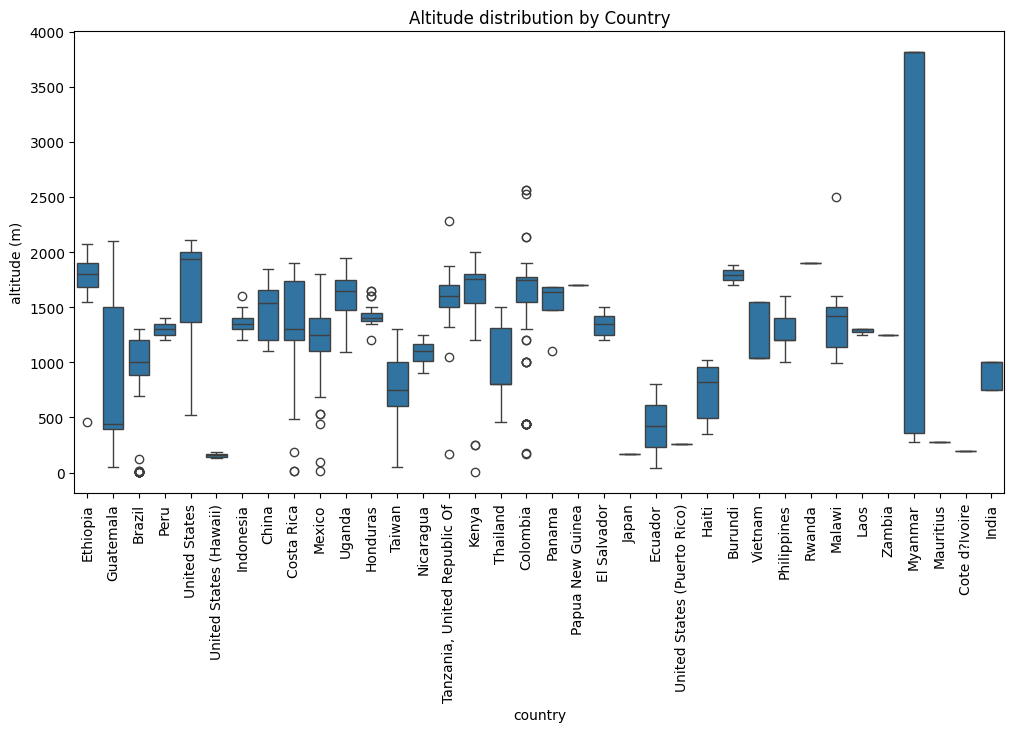

In [72]:
# altitude distribution per country
plt.figure(figsize=(12,6))
sns.boxplot(data=coffee_data, x='country_of_origin', y='altitude_mean_meters')
plt.xticks(rotation=90)
plt.title("Altitude distribution by Country")
plt.xlabel("country")
plt.ylabel("altitude (m)")
plt.show()

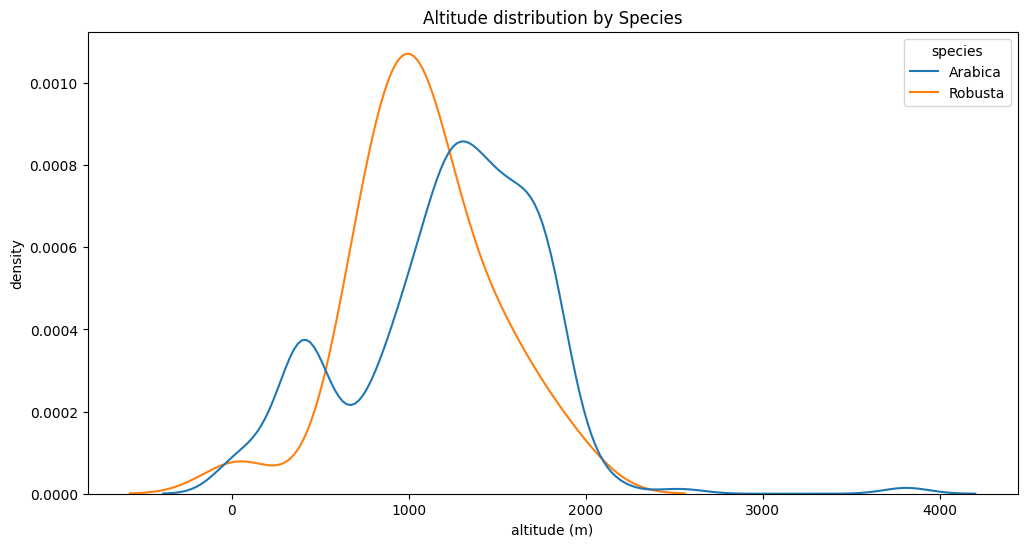

In [73]:
# KDE visualization of altitude distribution by species
plt.figure(figsize=(12,6))
sns.kdeplot(data=coffee_data, x='altitude_mean_meters', hue='species', common_norm=False)
plt.title("Altitude distribution by Species")
plt.xlabel("altitude (m)")
plt.ylabel("density")
plt.show()

### Correlation analysis

In [74]:
# correlation check
correlation_matrix = coffee_data.corr(numeric_only=True)
display(correlation_matrix)

,altitude_mean_meters,harvest_year,aroma,flavor,aftertaste,acidity,body,balance,uniformity,sweetness,moisture,clean_cup,quakers,category_one_defects,category_two_defects,total_cup_points
altitude_mean_meters,1.000000,-0.005292,0.112719,0.120484,0.150554,0.098913,0.107422,0.126394,0.043467,0.058581,-0.041589,0.041133,-0.012868,-0.049827,-0.005742,0.173989
harvest_year,-0.005292,1.000000,-0.058904,-0.036809,-0.048209,-0.064859,-0.062070,-0.055051,-0.000371,-0.004573,-0.089504,0.045682,0.292917,-0.053542,-0.103072,0.006362
aroma,0.112719,-0.058904,1.000000,0.812690,0.776198,0.722774,0.674467,0.709806,0.367716,0.254320,-0.133975,0.336628,0.008731,-0.096828,-0.149456,0.618340
flavor,0.120484,-0.036809,0.812690,1.000000,0.895386,0.816196,0.737004,0.793336,0.411944,0.291816,-0.145059,0.397833,0.004782,-0.089190,-0.192377,0.749698
aftertaste,0.150554,-0.048209,0.776198,0.895386,1.000000,0.791649,0.736242,0.811347,0.402897,0.267425,-0.180475,0.387917,0.000598,-0.105295,-0.210671,0.743937
acidity,0.098913,-0.064859,0.722774,0.816196,0.791649,1.000000,0.707592,0.733904,0.376296,0.262522,-0.128914,0.301622,-0.014108,-0.084641,-0.137137,0.629451
body,0.107422,-0.062070,0.674467,0.737004,0.736242,0.707592,1.000000,0.757611,0.326856,0.268321,-0.147686,0.276568,-0.004197,-0.044496,-0.085374,0.568903
balance,0.126394,-0.055051,0.709806,0.793336,0.811347,0.733904,0.757611,1.000000,0.400938,0.283286,-0.199840,0.370355,0.007619,-0.082413,-0.171104,0.700807
uniformity,0.043467,-0.000371,0.367716,0.411944,0.402897,0.376296,0.326856,0.400938,1.000000,0.451056,0.013739,0.526197,0.027441,-0.105853,-0.145815,0.490890
sweetness,0.058581,-0.004573,0.254320,0.291816,0.267425,0.262522,0.268321,0.283286,0.451056,1.000000,0.072660,0.440623,0.008666,-0.150783,-0.024980,0.393203


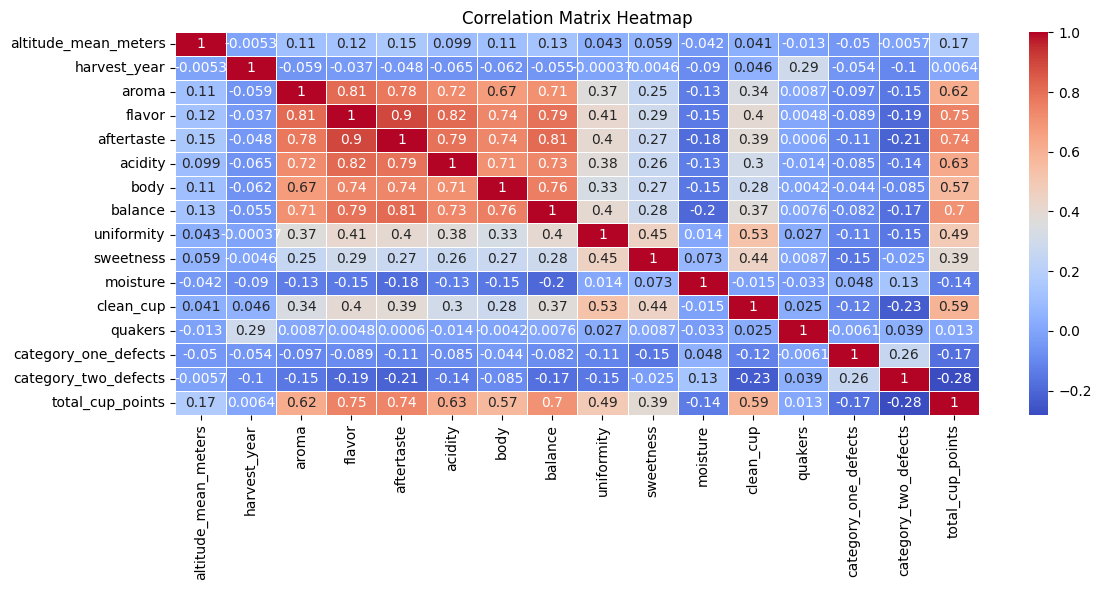

In [75]:
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix,
            annot=True,      # showing correlation values on the heatmap
            cmap='coolwarm', # choosing a colormap
            linewidths=0.5)  # adding lines between cells
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

#### Quakers vs. harvest year

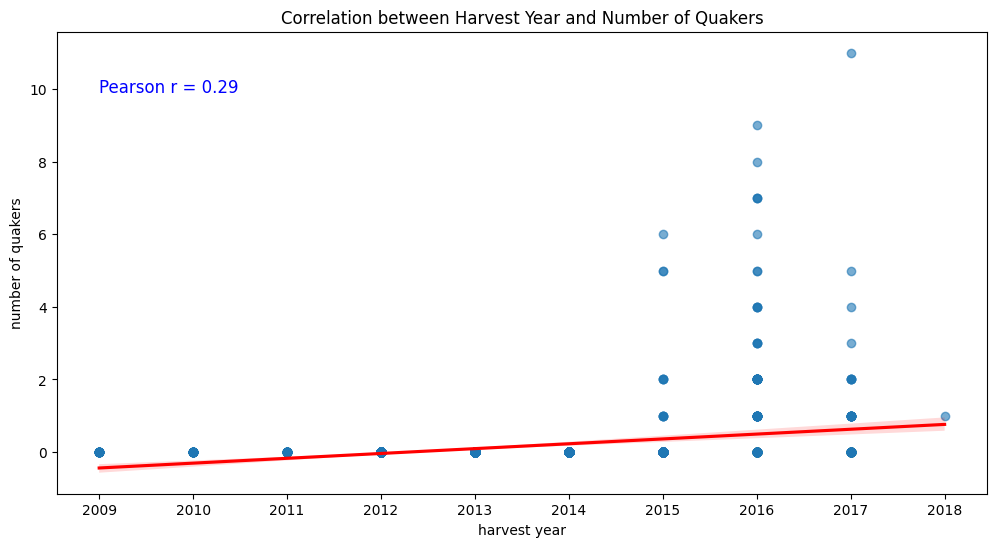

In [76]:
# relationship between harvest year and the number of quakers
corr = coffee_data[['harvest_year', 'quakers']].corr().loc['harvest_year', 'quakers']
plt.figure(figsize=(12,6))
sns.regplot(data=coffee_data, x='harvest_year', y='quakers', scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.xlabel("harvest year")
plt.ylabel("number of quakers")
plt.title("Correlation between Harvest Year and Number of Quakers")
plt.xticks(sorted(coffee_data['harvest_year'].dropna().unique()))
# annotating correlation coefficient on the plot
plt.text(
    x=coffee_data['harvest_year'].min(), 
    y=coffee_data['quakers'].max()*0.9, 
    s=f"Pearson r = {corr:.2f}", 
    fontsize=12, 
    color='blue'
)
plt.show()

In [77]:
coffee_data[coffee_data['harvest_year']==2014]['quakers'].unique()

array([0])

__Conclusion:__

For the years 2009–2014, all quakers values are recorded as 0 in the dataset. \
This likely indicates one of the following:
- Missing or unreported data: no measurements were recorded, and 0 was used as a placeholder.
- Data entry issue: the values may have been incorrectly filled with 0 instead of actual counts.

Implications:
- Any analysis of trends in quakers over time should treat these early years with caution.
- Using these 0s as actual measurements could bias correlation and regression results, underestimating the true number of quakers in early years.

The Pearson correlation coefficient between harvest year and quakers is 0.29:
- direction: positive (0.29 > 0). As harvest year increases, the number of quakers tends to increase slightly.
- strength: 0.29 is weak to moderate correlation. It suggests a trend, but the relationship is not very strong.
- linearity: Pearson measures linear correlation only. If the relationship is non-linear, Pearson might underestimate it.

Over the years, there’s a slight upward trend in the number of quakers, but it’s not strong enough to predict quakers solely from the year.

#### Coffee quality by species

In [78]:
coffee_data.groupby('species').agg(
    count_samples=('species', 'count'),
    n_countries=('country_of_origin', 'nunique'),
    total_points=('total_cup_points', 'sum'),
    avg_points=('total_cup_points', 'mean')      # average coffee quality score per specie 
).assign(
    normalized_points=lambda x: x.total_points / x.count_samples * 100,
    pct_normalized=lambda x: (x.normalized_points / x.normalized_points.sum() * 100).round(2)
)

,count_samples,n_countries,total_points,avg_points,normalized_points,pct_normalized
species,,,,,,
Arabica,1310,36,107648.534,82.174453,8217.445344,50.4
Robusta,28,5,2264.330,80.868929,8086.892857,49.6


#### Coffee quality by altitude and species

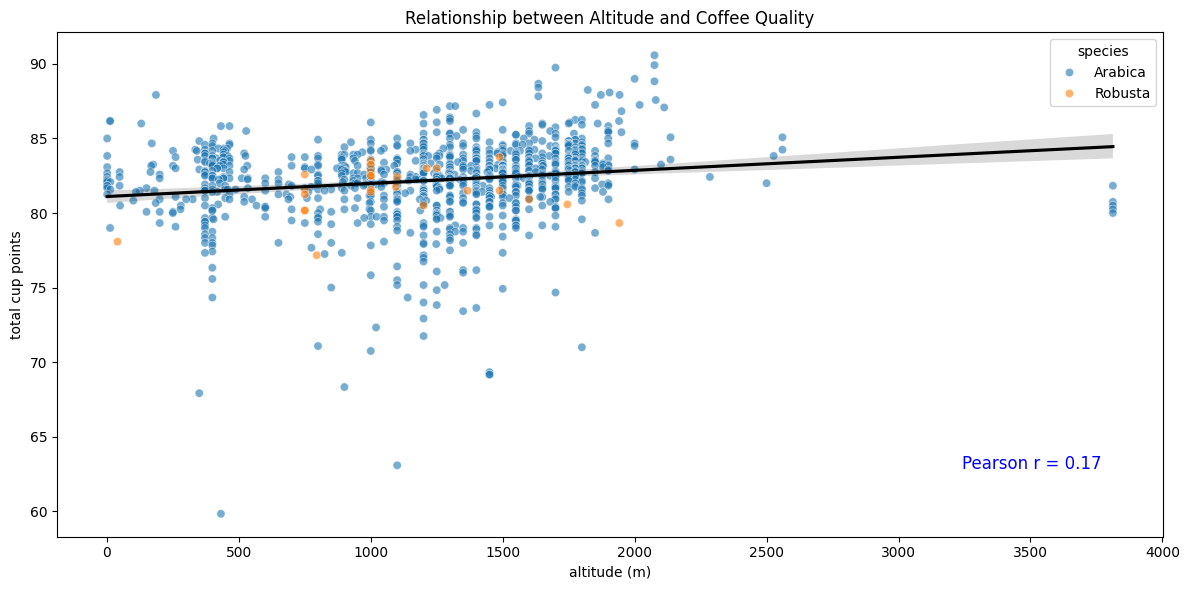

In [79]:
# relationship between altitude and cup quality
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=coffee_data,
    x='altitude_mean_meters',
    y='total_cup_points',
    hue='species',
    alpha=0.6
)
sns.regplot(
    data=coffee_data,
    x='altitude_mean_meters',
    y='total_cup_points',
    scatter=False,
    color='black'
)
# annotating correlation coefficient on the plot
correlation = coffee_data[['altitude_mean_meters', 'total_cup_points']].corr().loc['altitude_mean_meters', 'total_cup_points']
plt.text(
    x=coffee_data['altitude_mean_meters'].max()*0.85, 
    y=coffee_data['total_cup_points'].min()*1.05, 
    s=f"Pearson r = {correlation:.2f}", 
    fontsize=12, 
    color='blue'
)
plt.title("Relationship between Altitude and Coffee Quality")
plt.xlabel("altitude (m)")
plt.ylabel("total cup points")
plt.tight_layout()
plt.show()

#### Coffee quality by processing method

In [80]:
coffee_data.groupby('processing_method').agg(
    count_samples=('processing_method', 'count'),
    n_countries=('country_of_origin', 'nunique'),
    total_points=('total_cup_points', 'sum'),
    avg_points=('total_cup_points', 'mean')      # average coffee quality score per specie 
).assign(
    normalized_points=lambda x: x.total_points / x.count_samples * 100,
    pct_normalized=lambda x: (x.normalized_points / x.normalized_points.sum() * 100).round(2)
).sort_values(by='pct_normalized', ascending=False)

,count_samples,n_countries,total_points,avg_points,normalized_points,pct_normalized
processing_method,,,,,,
Honey,14,6,1159.310,82.807857,8280.785714,20.13
Semi-washed,66,8,5457.980,82.696667,8269.666667,20.11
Natural,317,24,26131.880,82.434953,8243.495268,20.04
Washed,911,33,74723.124,82.023188,8202.318771,19.94
Other,30,11,2440.570,81.352333,8135.233333,19.78


#### Coffee quality by country of origin

In [81]:
quality_by_country = coffee_data.groupby('country_of_origin').agg(
    count_samples=('country_of_origin', 'count'),
    total_points=('total_cup_points', 'sum'),
    avg_points=('total_cup_points', 'mean')      # average coffee quality score per country 
).assign(
    normalized_points=lambda x: x.total_points / x.count_samples * 100,
    pct_normalized=lambda x: (x.normalized_points / x.normalized_points.sum() * 100).round(2)
).sort_values(by='pct_normalized', ascending=False)

quality_by_country

,count_samples,total_points,avg_points,normalized_points,pct_normalized
country_of_origin,,,,,
Papua New Guinea,1,85.750,85.750000,8575.000000,2.90
Ethiopia,44,3761.300,85.484091,8548.409091,2.89
United States,10,844.330,84.433000,8443.300000,2.86
Japan,1,84.670,84.670000,8467.000000,2.86
Kenya,25,2107.740,84.309600,8430.960000,2.85
Panama,4,334.830,83.707500,8370.750000,2.83
Uganda,36,3004.270,83.451944,8345.194444,2.82
El Salvador,21,1744.110,83.052857,8305.285714,2.81
Colombia,183,15208.500,83.106557,8310.655738,2.81


In [82]:
# top N countries with the best coffee quality: a list of country names (pandas Series)
top_n = 5
top_countries = quality_by_country.head(top_n).index
top_countries

Index(['Papua New Guinea', 'Ethiopia', 'United States', 'Japan', 'Kenya'], dtype='object', name='country_of_origin')

In [83]:
# filtering the original DataFrame
top_quality = coffee_data[coffee_data['country_of_origin'].isin(top_countries)]
print('The number of entries for top countries: ', top_quality['country_of_origin'].count(), "\n")
top_quality.tail()

The number of entries for top countries:  81 



,species,country_of_origin,altitude_mean_meters,harvest_year,processing_method,aroma,flavor,aftertaste,acidity,body,balance,uniformity,sweetness,moisture,clean_cup,quakers,category_one_defects,category_two_defects,total_cup_points
1093,Arabica,Ethiopia,NaN,2010,Washed,7.25,7.25,7.25,7.33,7.50,8.00,9.33,10.00,0.10,9.33,0,0,1,80.33
1129,Arabica,Ethiopia,NaN,2010,Washed,7.42,7.42,7.50,7.92,7.75,7.58,8.67,8.67,0.05,9.33,0,0,2,80.00
1139,Arabica,Kenya,1500.0,2017,Washed,7.00,7.08,7.00,7.17,7.25,7.25,10.00,10.00,0.11,10.00,1,0,5,79.83
1333,Robusta,United States,1942.0,2012,Natural,7.92,7.50,7.42,7.42,7.42,7.42,9.33,7.58,0.00,10.00,0,0,0,79.33
1336,Robusta,United States,795.0,2014,Natural,7.33,7.33,7.17,7.42,7.50,7.17,9.33,7.42,0.00,9.33,0,0,6,77.17


### Time series analysis

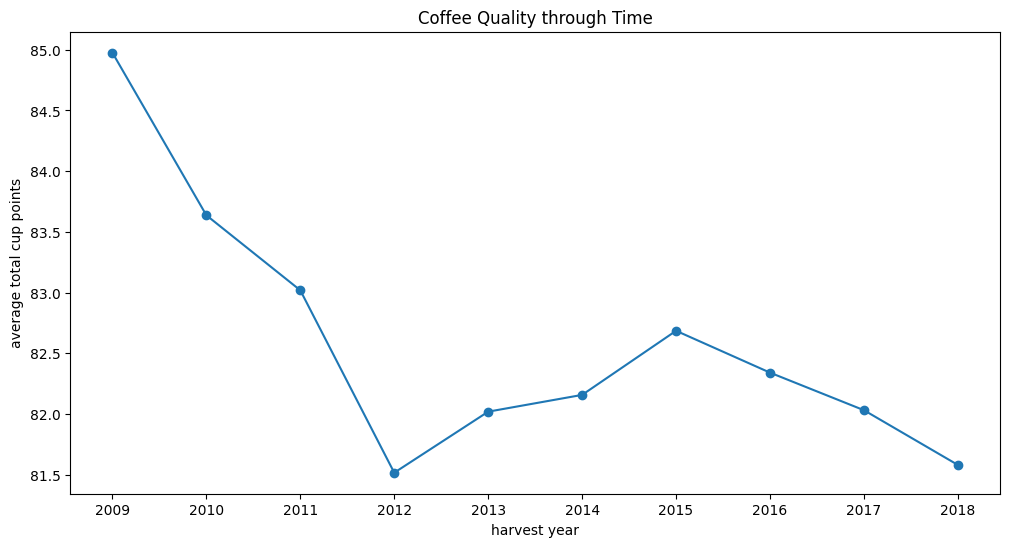

In [84]:
# relationship between coffee quality and harvest year
# groupby produces a Series where index = years and values = yearly averages
# passing the Series directly to plt.plot() automatically uses: index → X, values → Y
plt.figure(figsize=(12, 6))
plt.plot(coffee_data.groupby('harvest_year')['total_cup_points'].mean().sort_index(), marker='o')
plt.xlabel('harvest year')
plt.ylabel('average total cup points')
plt.title('Coffee Quality through Time')
plt.xticks(sorted(coffee_data['harvest_year'].dropna().unique()))
plt.show()

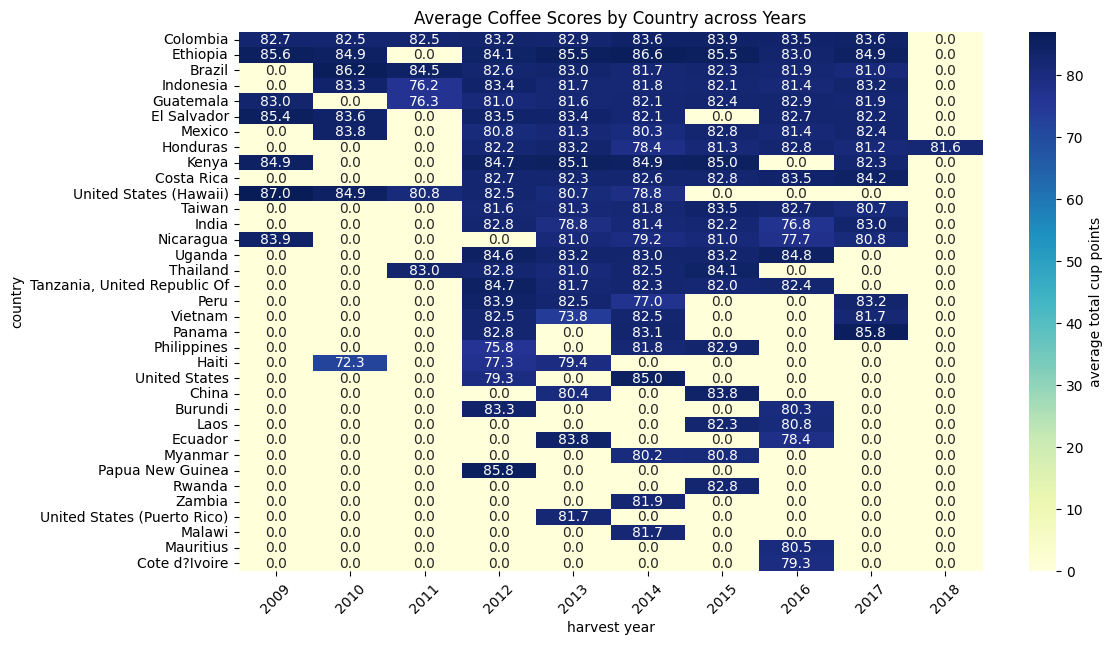

In [85]:
# average coffee scores by country across years, sorted by each country’s average score for all years

# pivot table
pivot = pd.pivot_table(
    coffee_data,
    values='total_cup_points',
    index='country_of_origin',
    columns='harvest_year',
    fill_value=0,
    margins=False
)

# sorting by row-wise mean
row_means = pivot.mean(axis=1)
pivot_sorted = pivot.loc[row_means.sort_values(ascending=False).index]

# heatmap
plt.figure(figsize=(12,7))
sns.heatmap(
    pivot_sorted,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={'label': 'average total cup points'}
)
plt.title("Average Coffee Scores by Country across Years")
plt.xlabel("harvest year")
plt.ylabel("country")
plt.xticks(rotation=45)
plt.show()

## Predictive analysis

__Goal:__ find which features most strongly affect total cup points, the overall coffee quality score.

__Approach:__ correlation & explainable machine learning (SHAP) to quantify and visualize which sensory and physical coffee attributes influence total cup points.

### Data preparation

In [86]:
data = coffee_data.copy()

In [87]:
# removing rows where total_cup_points is NaN
data = data.dropna(subset=['total_cup_points'])

In [88]:
# choosing predictor columns: focus on sensory and physical attributes
features = [
    'aroma', 'flavor', 'aftertaste', 'acidity', 'body', 
    'balance', 'uniformity', 'sweetness', 'moisture', 'clean_cup', 
    'quakers', 'category_one_defects', 'category_two_defects'
]

target = 'total_cup_points'

X = data[features]
y = data[target]

In [89]:
# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Correlation analysis

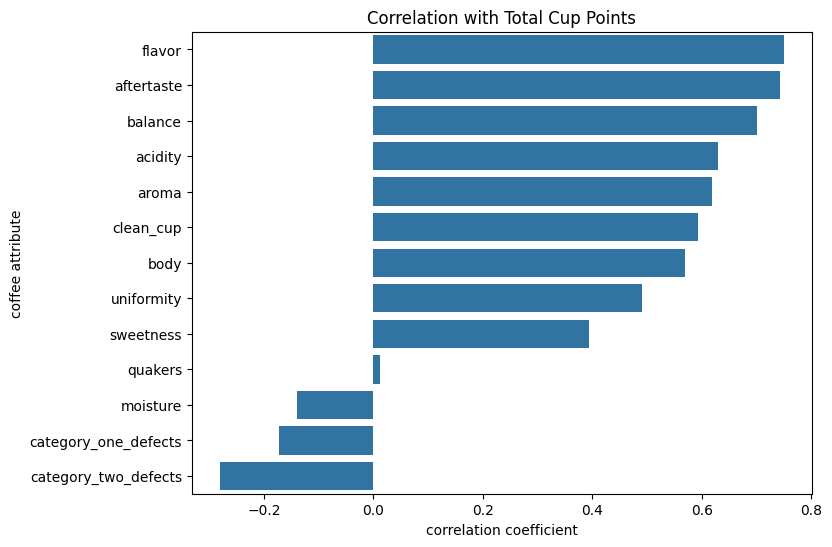

In [90]:
# visualizing linear relationships to identify influential attributes
corr_check = X.corrwith(y).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=corr_check.values, y=corr_check.index)
plt.title('Correlation with Total Cup Points')
plt.xlabel('correlation coefficient')
plt.ylabel('coffee attribute')
plt.show()

__Interpretation__
- Correlation provides a global view of linear relationships between attributes and overall coffee quality.
- It shows only linear effect and ignores feature interactions.
- It highlights features that have strong linear influence on cup points:
    - Positive: higher feature values tend to increase cup points.
    - Negative: higher feature values tend to decrease cup points.
    - Near 0: little linear relationship.

### Random Forest Modeling

In [91]:
# fitting a Random Forest regression model to capture non-linear influence and interactions
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [92]:
# making predictions on test set
y_pred = rf.predict(X_test)

In [93]:
# model performance evaluation
print("R²:", r2_score(y_test, y_pred), " MAE:", mean_absolute_error(y_test, y_pred))

R²: 0.9198767938344995  MAE: 0.3590979388770456


__Interpretation of the model metrics__ \
R² = 0.92:
- 92% of the variance in Total Cup Points is explained by features. \
Most of the variation in coffee quality score is captured by the sensory attributes. \
Only 8% of the variation are factors that are not included in the training dataset.
- The model has very strong predictive power.

MAE = 0.36:
- The model’s average prediction error is 0.36 points out of 100.
- The model makes predictions that are very accurate and within 1/3 of a point from the true score.

__Conclusion__ \
The Random Forest model predicts the coffee’s total cup points with high accuracy. \
It can explain almost all variability in the scores (R² ≈ 0.92). \
Its predictions differ from the true value by only about 0.36 points on average, which is extremely precise for sensory evaluation data.

### Random Forest feature importances

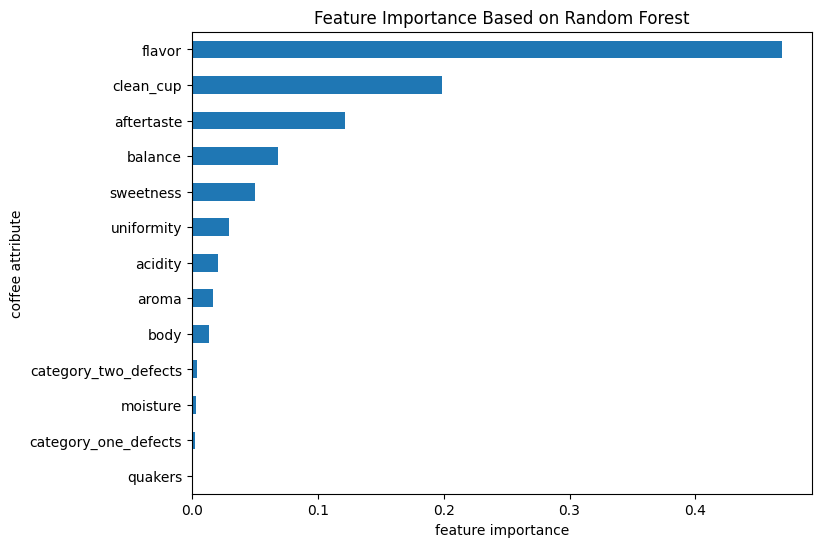

In [94]:
# global feature importance based on tree splits
importance = pd.Series(rf.feature_importances_, index=features).sort_values()
importance.plot(kind='barh', figsize=(8,6))
plt.title('Feature Importance Based on Random Forest')
plt.xlabel('feature importance')
plt.ylabel('coffee attribute')
plt.show()

__Interpretation__
- Each bar represents how much that feature contributed to reducing variance across all trees in the forest.
- Higher value: feature is more “important” for predicting Total Cup Points.
- Does not show direction: whether a high value increases or decreases the score.
- Flavor has the highest bar: it is the feature the Random Forest relied on most to split nodes and reduce error.

### Explainable ML with SHAP

__Bar plot of feature importance__

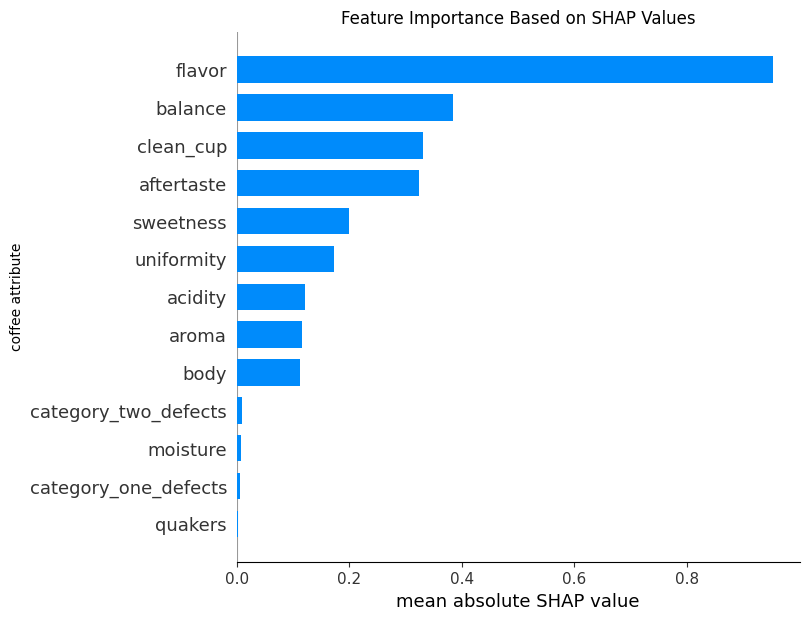

In [95]:
# computing SHAP values for the Random Forest model
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# a bar plot of mean absolute SHAP values
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)   # prevent auto-show

# customizing the figure
plt.gcf().set_size_inches(8, 6)     # get the current figure to adjust size and labels
plt.title("Feature Importance Based on SHAP Values")
plt.xlabel("mean absolute SHAP value")
plt.ylabel('coffee attribute')
plt.show()

__Interpretation__
- Shows mean absolute contribution of each feature to predictions.
- Gives a more reliable global ranking than RF importances, because it is less biased toward high-cardinality or high-range features.
- Does not show the direction of influence: positive vs negative.
- Flavor has the largest mean absolute SHAP value: it is the most influential feature in determining total cup points, on average.

__Swarm plot of directional influence__

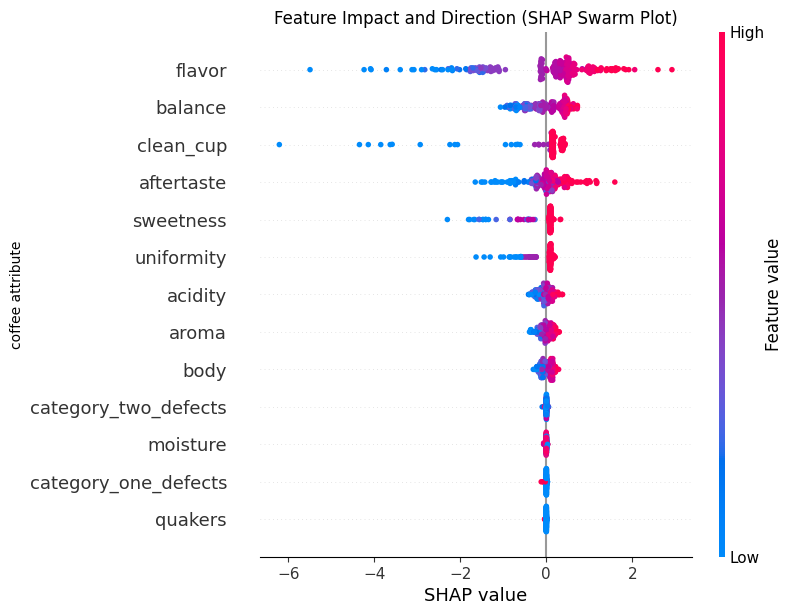

In [96]:
# a SHAP swarm plot to visualize feature impact and direction
shap.summary_plot(shap_values, X_test, show=False)

# customizing the figure
plt.gcf().set_size_inches(8, 6)
plt.title("Feature Impact and Direction (SHAP Swarm Plot)")
plt.xlabel("SHAP value")
plt.ylabel('coffee attribute')
plt.show()

__Interpretation__
- Shows individual feature impact on prediction, direction & magnitude of influence.
- Each point: one sample in the dataset.
- X-axis (SHAP value): impact on model output:
    - Positive: increases predicted cup points.
    - Negative: decreases predicted cup points.
- Color: original feature value:
    - red = high
    - blue = low
- Clean cup points are mostly red on the right and blue on the left:
    - High clean cup: increases total cup points.
    - Low clean cup: decreases total cup points.

## Data Export for Tableau

In [97]:
# exporting cleaned coffee dataset
coffee_data.to_csv("coffee_tableau.csv")
print("Cleaned coffee dataset exported successfully with shape:", coffee_data.shape)

Cleaned coffee dataset exported successfully with shape: (1338, 19)


In [98]:
# converting SHAP values to dataframe
shap_df = pd.DataFrame(shap_values, columns=features, index=X_test.index)

In [99]:
# selecting test samples from original data to keep metadata intact
# export_df will include metadata + sensory attributes + target
export_df = data.loc[X_test.index].copy()

In [100]:
# adding predictions, error and SHAP values
export_df['predicted_score'] = y_pred
export_df['error'] = export_df['predicted_score'] - export_df['total_cup_points']
export_df = pd.concat([export_df, shap_df.add_prefix('shap_')], axis=1)
# adding top contributing feature per sample
export_df['top_feature'] = shap_df.abs().idxmax(axis=1)

In [101]:
# exporting coffee predictions
export_df.to_csv('coffee_forecast_tableau.csv', index=False)
print("Coffee predictions exported successfully with shape:", export_df.shape)

Coffee predictions exported successfully with shape: (268, 35)


In [102]:
# exporting Random Forest feature importance (tree splits)
rf_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
rf_importance_df = rf_importance.reset_index()
rf_importance_df.columns = ['feature', 'importance_rf']
rf_importance_df.to_csv('feature_importance_rf.csv', index=False)
print("Random Forest feature importance exported with shape:", rf_importance_df.shape)

Random Forest feature importance exported with shape: (13, 2)


In [103]:
# exporting global SHAP feature importance (mean absolute SHAP values per feature)
mean_abs_shap = pd.DataFrame(shap_df.abs().mean().sort_values(ascending=False)).reset_index()
mean_abs_shap.columns = ['feature', 'importance_shap']
mean_abs_shap.to_csv('feature_importance_shap.csv', index=False)
print("Global SHAP feature importance exported with shape:", mean_abs_shap.shape)

Global SHAP feature importance exported with shape: (13, 2)
